# 1: Install required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""
Content-Based Filtering for Blog Recommendation System - Google Colab Version
For single combined dataset (cleaned_blog_ratings.pkl)
"""


print("Installing required packages...")
!pip install --quiet sentence-transformers
!pip install --quiet "umap-learn[plot]"
!pip install --quiet tqdm


Installing required packages...


# 2: Import libraries

In [1]:

import os
import pickle
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# Cell 3: Create directory structure and upload file


In [2]:
def setup_and_upload():
    """Create directories and upload the combined pickle file."""
    # Create directories
    directories = ['data', 'model', 'visualizations']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")

    print(f"\nCurrent working directory: {os.getcwd()}")

    # Upload file
    print("\n" + "="*50)
    print("UPLOAD YOUR PICKLE FILE")
    print("="*50)
    print("Please upload your cleaned_blog_ratings.pkl file")
    print("This should contain user-level and blog-level data with ratings")
    print("="*50 + "\n")

    uploaded = files.upload()

    # Move file to data directory
    uploaded_file = None
    for filename in uploaded.keys():
        # Move to data directory
        new_path = f'data/{filename}'
        os.rename(filename, new_path)
        uploaded_file = new_path
        print(f"✓ Uploaded and moved: {filename} → {new_path}")

        # Show file size
        file_size = os.path.getsize(new_path) / (1024 * 1024)  # Convert to MB
        print(f"  File size: {file_size:.2f} MB")

    print("\nFiles in data directory:")
    !ls -lh data/

    return uploaded_file

# Run this cell to upload file
uploaded_file = setup_and_upload()

Created directory: data
Created directory: model
Created directory: visualizations

Current working directory: /content

UPLOAD YOUR PICKLE FILE
Please upload your cleaned_blog_ratings.pkl file
This should contain user-level and blog-level data with ratings



Saving cleaned_blog_ratings.pkl to cleaned_blog_ratings.pkl
✓ Uploaded and moved: cleaned_blog_ratings.pkl → data/cleaned_blog_ratings.pkl
  File size: 20.30 MB

Files in data directory:
total 21M
-rw-r--r-- 1 root root 21M Jun 25 20:10 cleaned_blog_ratings.pkl


# 4: Load and explore the combined dataset


In [3]:
def load_and_explore_data(file_path):
    """
    Load and explore the combined blog-ratings dataset.

    Parameters:
    -----------
    file_path : str
        Path to the pickle file

    Returns:
    --------
    pd.DataFrame
        The loaded dataframe
    """
    print("="*50)
    print("LOADING AND EXPLORING DATA")
    print("="*50)

    # Load data
    print(f"\nLoading data from: {file_path}")
    df = pd.read_pickle(file_path)

    print(f"\n✓ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")

    # Display basic statistics
    print("\n" + "-"*30)
    print("DATA OVERVIEW")
    print("-"*30)

    # Check for required columns
    required_cols = ['user_id', 'blog_id', 'ratings', 'blog_title', 'blog_content', 'topic']
    missing_cols = set(required_cols) - set(df.columns)
    if missing_cols:
        print(f"⚠ Warning: Missing columns: {missing_cols}")
    else:
        print("✓ All required columns present")

    # Display statistics
    print(f"\nUnique users: {df['user_id'].nunique()}")
    print(f"Unique blogs: {df['blog_id'].nunique()}")
    print(f"Total ratings: {len(df)}")

    if 'topic' in df.columns:
        print(f"\nUnique topics: {df['topic'].nunique()}")
        print("Topics distribution:")
        print(df['topic'].value_counts().head(10))

    if 'ratings' in df.columns:
        print(f"\nRating statistics:")
        print(f"- Min: {df['ratings'].min()}")
        print(f"- Max: {df['ratings'].max()}")
        print(f"- Mean: {df['ratings'].mean():.2f}")
        print(f"- Std: {df['ratings'].std():.2f}")

    # Check user rating counts
    user_counts = df['user_id'].value_counts()
    print(f"\nUser activity:")
    print(f"- Min ratings per user: {user_counts.min()}")
    print(f"- Max ratings per user: {user_counts.max()}")
    print(f"- Avg ratings per user: {user_counts.mean():.2f}")

    # Display sample data
    print("\n" + "-"*30)
    print("SAMPLE DATA (first 3 rows)")
    print("-"*30)
    display(df.head(3))

    return df

# Load the data
df = load_and_explore_data(uploaded_file)

LOADING AND EXPLORING DATA

Loading data from: data/cleaned_blog_ratings.pkl

✓ Data loaded successfully!
Shape: (200140, 12)

Columns: ['blog_id', 'user_id', 'ratings', 'author_id', 'blog_title', 'blog_content', 'blog_link', 'blog_img', 'topic', 'scrape_time', 'scrape_date', 'author_name']

------------------------------
DATA OVERVIEW
------------------------------
✓ All required columns present

Unique users: 5001
Unique blogs: 9706
Total ratings: 200140

Unique topics: 23
Topics distribution:
topic
flutter                 15518
android                 14193
app-development         13933
Software-Development    13754
web-development         13397
backend-development      9209
backend                  9175
Cryptocurrency           7939
cybersecurity            7875
web3                     7748
Name: count, dtype: int64

Rating statistics:
- Min: 0.5
- Max: 5.0
- Mean: 3.12
- Std: 1.77

User activity:
- Min ratings per user: 1
- Max ratings per user: 374
- Avg ratings per user: 40.02


,blog_id,user_id,ratings,author_id,blog_title,blog_content,blog_link,blog_img,topic,scrape_time,scrape_date,author_name
0,9025,11,3.5,5960,How I became a Frontend Developer,A little bit of background about me: as a teen...,https://medium.com/@steven.dornan93/how-i-beca...,https://miro.medium.com/v2/resize:fill:140:140...,web-development,2023-04-04 08:53:52,2023-04-04,Steven Dornan
1,9320,11,5.0,6155,Writing an Algorithm to Calculate Article Read...,You have probably noticed a read-time number u...,https://medium.com/@dpericich/writing-an-algor...,https://miro.medium.com/v2/resize:fill:140:140...,web-development,2023-04-04 08:53:52,2023-04-04,Daniel Pericich
2,9246,11,3.5,6114,Diving into HTML and the Tools of the Trade,It’s been an incredible first week as a Bytewi...,https://medium.com/@muhammadnaeemtahir/diving-...,https://miro.medium.com/v2/resize:fill:140:140...,web-development,2023-04-04 08:53:52,2023-04-04,Muhammad Naeem Tahir


# 5: Prepare unique blog data for embeddings


In [ ]:
def prepare_blog_data(df):
    """
    Extract unique blog information and include average rating per blog.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined dataset with user-blog-rating information

    Returns:
    --------
    pd.DataFrame
        DataFrame with unique blog information and avg_rating column
    """
    print("\n" + "="*50)
    print("PREPARING UNIQUE BLOG DATA (with average ratings)")
    print("="*50)

    # 1. Compute average rating per blog
    avg_ratings = (
        df.groupby('blog_id')['ratings']
          .mean()
          .rename('avg_rating')
          .reset_index()
    )
    print(f"✓ Computed average rating for {len(avg_ratings)} blogs")

    # 2. Define the blog metadata columns
    blog_columns = ['blog_id', 'blog_title', 'blog_content', 'topic']
    if 'author_name' in df.columns:
        blog_columns.append('author_name')
    for col in ['author_id', 'blog_link', 'blog_img']:
        if col in df.columns:
            blog_columns.append(col)

    print(f"Extracting unique blogs with columns: {blog_columns}")

    # 3. Extract unique blog rows
    unique_blogs = (
        df[blog_columns]
        .drop_duplicates(subset=['blog_id'])
        .reset_index(drop=True)
    )
    print(f"✓ Extracted {len(unique_blogs)} unique blogs")

    # 4. Merge in the avg_rating
    unique_blogs = unique_blogs.merge(avg_ratings, on='blog_id', how='left')
    print("✓ Merged average ratings into unique_blogs")
    print(f"Final shape: {unique_blogs.shape}")

    return unique_blogs

unique_blogs = prepare_blog_data(df)
display(unique_blogs.head())


PREPARING UNIQUE BLOG DATA (with average ratings)
✓ Computed average rating for 9706 blogs
Extracting unique blogs with columns: ['blog_id', 'blog_title', 'blog_content', 'topic', 'author_name', 'author_id', 'blog_link', 'blog_img']
✓ Extracted 9706 unique blogs
✓ Merged average ratings into unique_blogs
Final shape: (9706, 9)


,blog_id,blog_title,blog_content,topic,author_name,author_id,blog_link,blog_img,avg_rating
0,9025,How I became a Frontend Developer,A little bit of background about me: as a teen...,web-development,Steven Dornan,5960,https://medium.com/@steven.dornan93/how-i-beca...,https://miro.medium.com/v2/resize:fill:140:140...,3.421053
1,9320,Writing an Algorithm to Calculate Article Read...,You have probably noticed a read-time number u...,web-development,Daniel Pericich,6155,https://medium.com/@dpericich/writing-an-algor...,https://miro.medium.com/v2/resize:fill:140:140...,3.237500
2,9246,Diving into HTML and the Tools of the Trade,It’s been an incredible first week as a Bytewi...,web-development,Muhammad Naeem Tahir,6114,https://medium.com/@muhammadnaeemtahir/diving-...,https://miro.medium.com/v2/resize:fill:140:140...,2.541667
3,9431,Learning Too Many Programming Languages at Once?,Learning too many programming languages at onc...,web-development,Mohit Singh,2386,https://medium.com/@mohit-singh/learning-too-m...,https://miro.medium.com/v2/resize:fill:140:140...,3.440000
4,875,Cryptocurrency Regulations: A Tug of War Betwe...,"Once upon a time in the wild, wild world of cr...",blockchain,Juan In The Chain,699,https://medium.com/@Juan_In_The_Chain/cryptocu...,https://miro.medium.com/v2/resize:fill:140:140...,3.800000


# 6: Content-based filtering functions

In [ ]:

def create_combined_text(blog_df):
    """Create a combined text field from blog title, content, and topic."""
    print("\nCreating combined text fields...")
    combined_text = (
        blog_df['blog_title'] + " " +
        blog_df['author_name'] + " " +
        blog_df['topic'] + " " +
        blog_df['blog_content'].str[:5000]  # First 5000 characters of content
    )
    print(f"✓ Combined text created for {len(combined_text)} blogs")
    return combined_text


def create_embeddings(combined_texts, model_name='sentence-transformers/all-mpnet-base-v2'):
  """Create embeddings for blog texts using sentence transformer."""
  print(f"\nLoading sentence transformer model: {model_name}")
  model = SentenceTransformer(model_name)

  print("Creating embeddings for all blogs...")
  print(f"This may take a while for {len(combined_texts)} blogs...")

  # Convert to list for sentence transformer
  text_list = combined_texts.tolist()

  # Create embeddings with progress bar
  embeddings = model.encode(
      text_list,
      show_progress_bar=True,
      batch_size=32
  )

  print(f"✓ Embeddings created with shape: {embeddings.shape}")
  return embeddings


def create_umap_visualization(embeddings, topics):
    """Create UMAP visualization of embeddings colored by topic."""
    print("\nCreating UMAP visualization...")

    # Create UMAP reducer
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        random_state=42
    )

    # Fit and transform
    print("Fitting UMAP...")
    umap_embeddings = reducer.fit_transform(embeddings)

    # Create plot
    plt.figure(figsize=(12, 8))

    # Get unique topics and create color map
    unique_topics = topics.unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_topics)))

    # Plot each topic
    for idx, topic in enumerate(unique_topics):
        mask = topics == topic
        plt.scatter(
            umap_embeddings[mask, 0],
            umap_embeddings[mask, 1],
            c=[colors[idx]],
            label=topic,
            alpha=0.7,
            s=10
        )

    plt.title("UMAP Visualization of Blog Embeddings", fontsize=16)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("✓ UMAP visualization complete")


def create_tsne_visualization(embeddings, topics):
    """Create t-SNE visualization of embeddings colored by topic."""
    print("\nCreating t-SNE visualization...")
    print("Note: t-SNE can be slow for large datasets...")

    # Sample if dataset is too large
    if len(embeddings) > 10000:
        print(f"Dataset has {len(embeddings)} samples. Sampling 10000 for t-SNE...")
        sample_indices = np.random.choice(len(embeddings), 10000, replace=False)
        embeddings_sample = embeddings[sample_indices]
        topics_sample = topics.iloc[sample_indices]
    else:
        embeddings_sample = embeddings
        topics_sample = topics

    # Create t-SNE reducer
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        n_iter=1000
    )

    # Fit and transform
    print("Fitting t-SNE...")
    tsne_embeddings = tsne.fit_transform(embeddings_sample)

    # Create plot
    plt.figure(figsize=(12, 8))

    # Get unique topics and create color map
    unique_topics = topics_sample.unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_topics)))

    # Plot each topic
    for idx, topic in enumerate(unique_topics):
        mask = topics_sample == topic
        plt.scatter(
            tsne_embeddings[mask, 0],
            tsne_embeddings[mask, 1],
            c=[colors[idx]],
            label=topic,
            alpha=0.7,
            s=10
        )

    plt.title("t-SNE Visualization of Blog Embeddings", fontsize=16)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("✓ t-SNE visualization complete")


def save_embedding_model(blog_ids, embeddings):
    """Save the embedding model to a pickle file."""
    model_path = 'model/embedding_model.pkl'
    print(f"\nSaving embedding model to {model_path}")

    # Create model dictionary
    embedding_model = {
        'blog_ids': np.array(blog_ids),
        'embeddings': embeddings,
        'embedding_dim': embeddings.shape[1],
        'n_blogs': embeddings.shape[0]
    }

    # Save pickle file
    with open(model_path, 'wb') as f:
        pickle.dump(embedding_model, f)

    print(f"✓ Embedding model saved successfully!")
    print(f"  Contains {embedding_model['n_blogs']} blogs with {embedding_model['embedding_dim']}-dimensional embeddings")


def get_content_recommendations(user_id, unique_blogs, embeddings, ratings_df, top_n=10):
    """Get content-based recommendations for a user."""
    print(f"\nGetting recommendations for user {user_id}...")

    # Get user's rated blogs
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]

    if len(user_ratings) == 0:
        print(f"No ratings found for user {user_id}, returning popular blogs")
        # Return most popular blogs as fallback
        popular_blogs = (
            ratings_df.groupby('blog_id')['ratings']
            .agg(['mean', 'count'])
            .sort_values(['mean', 'count'], ascending=False)
            .head(top_n)
        )
        result_df = unique_blogs[unique_blogs['blog_id'].isin(popular_blogs.index)].copy()
        result_df['score'] = result_df['blog_id'].map(dict(zip(popular_blogs.index, popular_blogs['mean'])))
        result_df['user_id'] = user_id

        # Add author_name if not present
        if 'author_name' not in result_df.columns:
            result_df['author_name'] = 'Unknown'

        return result_df[['user_id', 'blog_id', 'score', 'blog_title',
                         'blog_content', 'author_name', 'topic']]

    # Get blogs the user liked (rating >= 4)
    liked_blogs = user_ratings[user_ratings['ratings'] >= 4]['blog_id'].values
    print(f"User has liked {len(liked_blogs)} blogs")

    if len(liked_blogs) == 0:
        print("User has no liked blogs (rating >= 4), using all rated blogs")
        liked_blogs = user_ratings['blog_id'].values

    # Get indices of liked blogs
    liked_indices = unique_blogs[unique_blogs['blog_id'].isin(liked_blogs)].index.values

    if len(liked_indices) == 0:
        print("No matching blogs found in unique_blogs, returning popular blogs")
        return get_content_recommendations(0, unique_blogs, embeddings, ratings_df, top_n)

    # Calculate mean embedding of liked blogs
    liked_embeddings = embeddings[liked_indices]
    user_profile = np.mean(liked_embeddings, axis=0).reshape(1, -1)

    # Calculate cosine similarity with all blogs
    similarities = cosine_similarity(user_profile, embeddings).flatten()

    # Get already rated blogs to exclude
    rated_blogs = user_ratings['blog_id'].values

    # Create recommendation dataframe
    rec_df = pd.DataFrame({
        'blog_id': unique_blogs['blog_id'],
        'score': similarities
    })

    # Exclude already rated blogs
    rec_df = rec_df[~rec_df['blog_id'].isin(rated_blogs)]

    # Sort by score and get top N
    rec_df = rec_df.sort_values('score', ascending=False).head(top_n)

    # Merge with blog information
    blog_cols = ['blog_id', 'blog_title', 'blog_content', 'topic']
    if 'author_name' in unique_blogs.columns:
        blog_cols.append('author_name')

    result_df = rec_df.merge(unique_blogs[blog_cols], on='blog_id')

    # Add author_name if not present
    if 'author_name' not in result_df.columns:
        result_df['author_name'] = 'Unknown'

    # Add user_id
    result_df['user_id'] = user_id

    # Reorder columns
    result_df = result_df[['user_id', 'blog_id', 'score', 'blog_title',
                          'blog_content', 'author_name', 'topic']]

    print(f"✓ Returning top {len(result_df)} recommendations")
    return result_df

# 7: Run the complete pipeline



RUNNING CONTENT-BASED FILTERING PIPELINE

Creating combined text fields...
✓ Combined text created for 9706 blogs

Loading sentence transformer model: sentence-transformers/all-mpnet-base-v2
Creating embeddings for all blogs...
This may take a while for 9706 blogs...


Batches:   0%|          | 0/304 [00:00<?, ?it/s]

✓ Embeddings created with shape: (9706, 768)

Creating UMAP visualization...
Fitting UMAP...


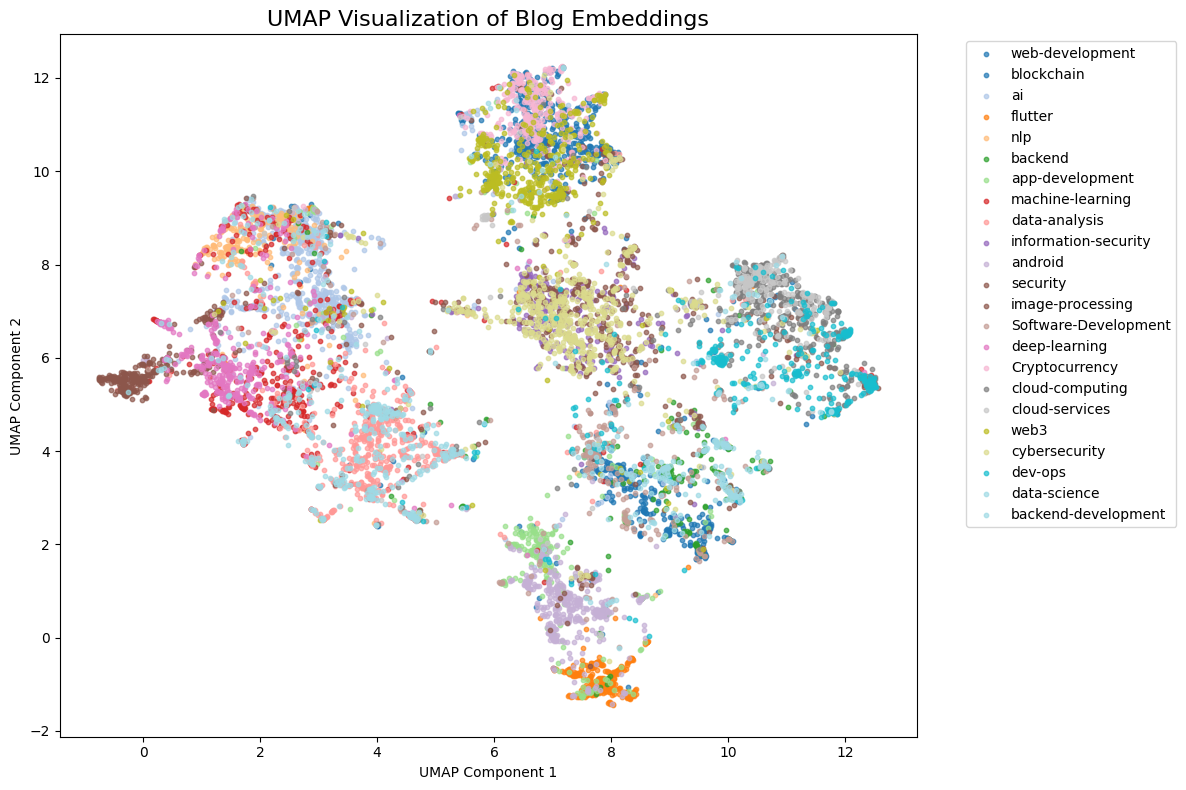

✓ UMAP visualization complete

Creating t-SNE visualization...
Note: t-SNE can be slow for large datasets...
Fitting t-SNE...


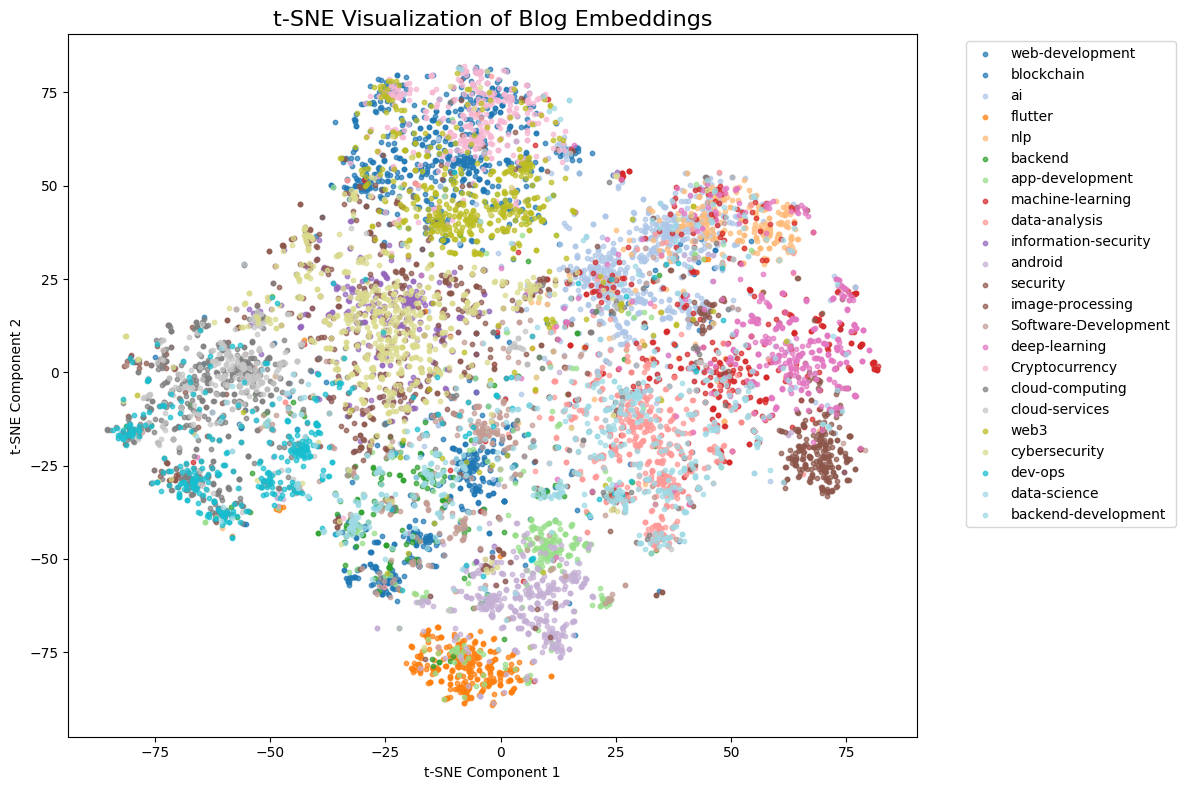

✓ t-SNE visualization complete

Saving embedding model to model/embedding_model.pkl
✓ Embedding model saved successfully!
  Contains 9706 blogs with 768-dimensional embeddings

TESTING RECOMMENDATION SYSTEM

Top 5 most active users:
user_id
3619    374
3882    299
4453    296
4012    295
4131    287
dtype: int64

Getting recommendations for user 3619...
User has liked 150 blogs
✓ Returning top 5 recommendations

Top 5 recommendations for user 3619:
--------------------------------------------------------------------------------

1. Crypto News Today — April 02, 2023
   Topic: blockchain
   Author: Crypto Beat
   Score: 0.8614
   Preview: If you’re interested in keeping up with the latest trends in the crypto world, then you’ve come to t...

2. Bitcoin’s banner quarter
   Topic: blockchain
   Author: Peter A. McKay
   Score: 0.8147
   Preview: #Web3Weekly: March 26 to April 1, 2023 —  This post is adapted from the latest edition of my newslet...

3. ZentaNews 3–18–2023
   Topic: blockch

In [ ]:
print("\n" + "="*60)
print("RUNNING CONTENT-BASED FILTERING PIPELINE")
print("="*60)

# Create combined text
combined_texts = create_combined_text(unique_blogs)

# Create embeddings
embeddings = create_embeddings(combined_texts)

# Create visualizations
create_umap_visualization(embeddings, unique_blogs['topic'])
create_tsne_visualization(embeddings, unique_blogs['topic'])

# Save embedding model
save_embedding_model(unique_blogs['blog_id'], embeddings)

# Test recommendations
print("\n" + "="*50)
print("TESTING RECOMMENDATION SYSTEM")
print("="*50)

# Get a sample user for testing
user_counts = df.groupby('user_id').size().sort_values(ascending=False)
print(f"\nTop 5 most active users:")
print(user_counts.head())

sample_user = user_counts.index[0]

recommendations = get_content_recommendations(
    user_id=sample_user,
    unique_blogs=unique_blogs,
    embeddings=embeddings,
    ratings_df=df,
    top_n=5
)

print(f"\nTop 5 recommendations for user {sample_user}:")
print("-"*80)
for idx, row in recommendations.iterrows():
    print(f"\n{idx+1}. {row['blog_title']}")
    print(f"   Topic: {row['topic']}")
    print(f"   Author: {row['author_name']}")
    print(f"   Score: {row['score']:.4f}")
    print(f"   Preview: {row['blog_content'][:100]}...")

# Show what this user has liked before
print("\n" + "-"*50)
print(f"What user {sample_user} has liked (rating >= 4):")
user_liked = df[(df['user_id'] == sample_user) & (df['ratings'] >= 4)].head(5)
for idx, row in user_liked.iterrows():
    print(f"\n- {row['blog_title']}")
    print(f"  Topic: {row['topic']}")
    print(f"  Rating: {row['ratings']}")

# 8: Download the results

In [ ]:
def download_results():
    """Download the embedding model."""
    print("\n" + "="*50)
    print("DOWNLOADING RESULTS")
    print("="*50)

    # Download embedding model
    files.download('model/embedding_model.pkl')
    print("✓ Downloaded: embedding_model.pkl")

# Download the model
download_results()

def create_recommendation_function():
    """Create a simple function that can be used to get recommendations."""

    code = '''
# Simple recommendation function using the saved embedding model

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recs_to_dataframe(recs, unique_blogs):
    """
    Convert recommendation list into a full DataFrame with metadata.

    Parameters:
    -----------
    recs : list of (blog_id, score) tuples
    unique_blogs : pd.DataFrame
        The DataFrame you created earlier in Cell 5, with one row per blog and
        columns like ['blog_id', 'blog_title', 'blog_content', 'topic', 'author_name', …]

    Returns:
    --------
    pd.DataFrame
        Columns: ['blog_id', 'score', 'blog_title', 'blog_content', 'topic', 'author_name', …]
    """
    # 1. Build a small DataFrame of just IDs and scores
    rec_df = pd.DataFrame(recs, columns=['blog_id', 'score'])

    # 2. Merge with the blog metadata
    full_rec_df = rec_df.merge(unique_blogs, on='blog_id', how='left')

    # 3. (Optional) Reorder columns to taste
    cols = ['blog_id', 'score']
    # pick up all the other metadata columns
    meta_cols = [c for c in unique_blogs.columns if c != 'blog_id']
    full_rec_df = full_rec_df[cols + meta_cols]

    return full_rec_df

def prepare_blog_data(df):
    """
    Extract unique blog information and include average rating per blog.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined dataset with user-blog-rating information

    Returns:
    --------
    pd.DataFrame
        DataFrame with unique blog information and avg_rating column
    """

    print("PREPARING UNIQUE BLOG DATA (with average ratings)")


    # 1. Compute average rating per blog
    avg_ratings = (
        df.groupby('blog_id')['ratings']
          .mean()
          .rename('avg_rating')
          .reset_index()
    )
    print(f"✓ Computed average rating for {len(avg_ratings)} blogs")

    # 2. Define the blog metadata columns
    blog_columns = ['blog_id', 'blog_title', 'blog_content', 'topic']
    if 'author_name' in df.columns:
        blog_columns.append('author_name')
    for col in ['author_id', 'blog_link', 'blog_img']:
        if col in df.columns:
            blog_columns.append(col)

    print(f"Extracting unique blogs with columns: {blog_columns}")

    # 3. Extract unique blog rows
    unique_blogs = (
        df[blog_columns]
        .drop_duplicates(subset=['blog_id'])
        .reset_index(drop=True)
    )
    print(f"✓ Extracted {len(unique_blogs)} unique blogs")

    # 4. Merge in the avg_rating
    unique_blogs = unique_blogs.merge(avg_ratings, on='blog_id', how='left')
    print("✓ Merged average ratings into unique_blogs")
    print(f"Final shape: {unique_blogs.shape}")

    return unique_blogs





def load_embedding_model(model_path='model/embedding_model.pkl'):
    """Load the saved embedding model."""
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def get_recommendations_for_user(user_id, df, embedding_model, top_n=10):
    """
    Get content-based recommendations for a user using saved embeddings.

    Parameters:
    - user_id: User ID
    - df: Original dataframe with ratings
    - embedding_model: Loaded embedding model
    - top_n: Number of recommendations
    """
    embeddings = embedding_model['embeddings']
    blog_ids = embedding_model['blog_ids']

    # Get user's liked blogs
    user_ratings = df[df['user_id'] == user_id]
    liked_blogs = user_ratings[user_ratings['ratings'] >= 4]['blog_id'].values

    # Find indices of liked blogs in embedding model
    blog_id_to_idx = {bid: idx for idx, bid in enumerate(blog_ids)}
    liked_indices = [blog_id_to_idx[bid] for bid in liked_blogs if bid in blog_id_to_idx]

    # Create user profile
    user_profile = np.mean(embeddings[liked_indices], axis=0).reshape(1, -1)

    # Calculate similarities
    similarities = cosine_similarity(user_profile, embeddings).flatten()

    # Get recommendations
    rated_blogs = set(user_ratings['blog_id'].values)
    recommendations = []

    for idx, (blog_id, score) in enumerate(zip(blog_ids, similarities)):
        if blog_id not in rated_blogs:
            recommendations.append((blog_id, score))

    # Sort and return top N
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

# Example usage:
embedding_model = load_embedding_model('model/embedding_model.pkl')
unique_blogs = prepare_blog_data(df)
recs = get_recommendations_for_user(user_id=123, df=df, embedding_model=embedding_model)
display(recs_to_dataframe(recs, unique_blogs).head())
'''

    with open('recommendation_function.py', 'w') as f:
        f.write(code)

    print("✓ Created recommendation_function.py")
    files.download('recommendation_function.py')

create_recommendation_function()

print("\n" + "="*60)
print("🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
print("="*60)
print("\nYou have downloaded:")
print("1. embedding_model.pkl - Contains blog embeddings")
print("2. recommendation_function.py - Simple function to get recommendations")
print("\nThe embedding model can be used for content-based filtering in your hybrid system!")


DOWNLOADING RESULTS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: embedding_model.pkl
✓ Created recommendation_function.py


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉

You have downloaded:
1. embedding_model.pkl - Contains blog embeddings
2. recommendation_function.py - Simple function to get recommendations

The embedding model can be used for content-based filtering in your hybrid system!


#  9: Testing simple recommendation function


In [ ]:
with open('model/embedding_model.pkl', 'rb') as f:
    embedding_model = pickle.load(f)

# Show model metadata
print("Model keys:", list(embedding_model.keys()))
print(f"Number of blogs (n_blogs): {embedding_model['n_blogs']}")
print(f"Embedding dimension (embedding_dim): {embedding_model['embedding_dim']}")

# Prepare the first row for display
first_blog_id = embedding_model['blog_ids'][0]
first_embedding = embedding_model['embeddings'][0]

Model keys: ['blog_ids', 'embeddings', 'embedding_dim', 'n_blogs']
Number of blogs (n_blogs): 9706
Embedding dimension (embedding_dim): 768


In [ ]:
embedding_model

{'blog_ids': array([9025, 9320, 9246, ..., 4459, 1353, 3200]),
 'embeddings': array([[ 0.06541736, -0.06112046, -0.04812232, ...,  0.01338807,
          0.05642473, -0.02321429],
        [ 0.03326834, -0.0055449 , -0.02290662, ..., -0.01019576,
         -0.02159709, -0.0308059 ],
        [ 0.05217094, -0.05301809, -0.03046702, ...,  0.02762103,
          0.03997626, -0.04578924],
        ...,
        [ 0.05231993, -0.02014233, -0.041589  , ...,  0.01548124,
         -0.03535191, -0.02759291],
        [ 0.0374677 ,  0.03404489, -0.0421144 , ..., -0.00343512,
          0.00237691, -0.0417092 ],
        [ 0.00957722,  0.03722151, -0.05027007, ...,  0.01685175,
         -0.0014475 , -0.009413  ]], dtype=float32),
 'embedding_dim': 768,
 'n_blogs': 9706}

In [4]:

# Simple recommendation function using the saved embedding model

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recs_to_dataframe(recs, unique_blogs):
    """
    Convert recommendation list into a full DataFrame with metadata.

    Parameters:
    -----------
    recs : list of (blog_id, score) tuples
    unique_blogs : pd.DataFrame
        The DataFrame you created earlier in Cell 5, with one row per blog and
        columns like ['blog_id', 'blog_title', 'blog_content', 'topic', 'author_name', …]

    Returns:
    --------
    pd.DataFrame
        Columns: ['blog_id', 'score', 'blog_title', 'blog_content', 'topic', 'author_name', …]
    """
    # 1. Build a small DataFrame of just IDs and scores
    rec_df = pd.DataFrame(recs, columns=['blog_id', 'score'])

    # 2. Merge with the blog metadata
    full_rec_df = rec_df.merge(unique_blogs, on='blog_id', how='left')

    # 3. (Optional) Reorder columns to taste
    cols = ['blog_id', 'score']
    # pick up all the other metadata columns
    meta_cols = [c for c in unique_blogs.columns if c != 'blog_id']
    full_rec_df = full_rec_df[cols + meta_cols]

    return full_rec_df

def prepare_blog_data(df):
    """
    Extract unique blog information and include average rating per blog.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined dataset with user-blog-rating information

    Returns:
    --------
    pd.DataFrame
        DataFrame with unique blog information and avg_rating column
    """

    print("PREPARING UNIQUE BLOG DATA (with average ratings)")


    # 1. Compute average rating per blog
    avg_ratings = (
        df.groupby('blog_id')['ratings']
          .mean()
          .rename('avg_rating')
          .reset_index()
    )
    print(f"✓ Computed average rating for {len(avg_ratings)} blogs")

    # 2. Define the blog metadata columns
    blog_columns = ['blog_id', 'blog_title', 'blog_content', 'topic']
    if 'author_name' in df.columns:
        blog_columns.append('author_name')
    for col in ['author_id', 'blog_link', 'blog_img']:
        if col in df.columns:
            blog_columns.append(col)

    print(f"Extracting unique blogs with columns: {blog_columns}")

    # 3. Extract unique blog rows
    unique_blogs = (
        df[blog_columns]
        .drop_duplicates(subset=['blog_id'])
        .reset_index(drop=True)
    )
    print(f"✓ Extracted {len(unique_blogs)} unique blogs")

    # 4. Merge in the avg_rating
    unique_blogs = unique_blogs.merge(avg_ratings, on='blog_id', how='left')
    print("✓ Merged average ratings into unique_blogs")
    print(f"Final shape: {unique_blogs.shape}")

    return unique_blogs





def load_embedding_model(model_path='model/embedding_model.pkl'):
    """Load the saved embedding model."""
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def get_recommendations_for_user(user_id, df, embedding_model, top_n=10):
    """
    Get content-based recommendations for a user using saved embeddings.

    Parameters:
    - user_id: User ID
    - df: Original dataframe with ratings
    - embedding_model: Loaded embedding model
    - top_n: Number of recommendations
    """
    embeddings = embedding_model['embeddings']
    blog_ids = embedding_model['blog_ids']

    # Get user's liked blogs
    user_ratings = df[df['user_id'] == user_id]
    liked_blogs = user_ratings[user_ratings['ratings'] >= 4]['blog_id'].values

    # Find indices of liked blogs in embedding model
    blog_id_to_idx = {bid: idx for idx, bid in enumerate(blog_ids)}
    liked_indices = [blog_id_to_idx[bid] for bid in liked_blogs if bid in blog_id_to_idx]

    # Create user profile
    user_profile = np.mean(embeddings[liked_indices], axis=0).reshape(1, -1)

    # Calculate similarities
    similarities = cosine_similarity(user_profile, embeddings).flatten()

    # Get recommendations
    rated_blogs = set(user_ratings['blog_id'].values)
    recommendations = []

    for idx, (blog_id, score) in enumerate(zip(blog_ids, similarities)):
        if blog_id not in rated_blogs:
            recommendations.append((blog_id, score))

    # Sort and return top N
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

# Example usage:
embedding_model = load_embedding_model('model/embedding_model.pkl')
unique_blogs = prepare_blog_data(df)
recs = get_recommendations_for_user(user_id=123, df=df, embedding_model=embedding_model)
display(recs_to_dataframe(recs, unique_blogs).head())

PREPARING UNIQUE BLOG DATA (with average ratings)
✓ Computed average rating for 9706 blogs
Extracting unique blogs with columns: ['blog_id', 'blog_title', 'blog_content', 'topic', 'author_name', 'author_id', 'blog_link', 'blog_img']
✓ Extracted 9706 unique blogs
✓ Merged average ratings into unique_blogs
Final shape: (9706, 9)


,blog_id,score,blog_title,blog_content,topic,author_name,author_id,blog_link,blog_img,avg_rating
0,8849,0.890300,Introducing Flutter: The basics to get you sta...,Have you ever wondered how mobile and web appl...,flutter,Jamiu Okanlawon,5881,https://medium.com/@developerjamiu/introducing...,https://miro.medium.com/v2/resize:fill:140:140...,3.125000
1,8999,0.867866,Flutter for Beginners: A Comprehensive Introdu...,"If you’re new to app development, you may have...",flutter,Adarsh Gabani,5791,https://medium.com/@adarshgabani/flutter-for-b...,https://miro.medium.com/v2/resize:fill:140:140...,3.156250
2,8731,0.856674,Flutter plugins and packages complete guide,Flutter is a powerful framework that enables d...,flutter,Muhammadumarch,5561,https://medium.com/@muhammadumarch321/flutter-...,https://miro.medium.com/v2/resize:fill:140:140...,3.223684
3,8097,0.852707,The perfect flutter boiler plate and state man...,"Yo, yo, yo, 148–3 to the 3 to the 6 to the 9, ...",android,Abdullahshahid,5442,https://medium.com/@abdullahshahid1071/the-per...,https://miro.medium.com/v2/resize:fill:140:140...,2.671053
4,8768,0.852083,How to Get Started with Flutter Development: A...,Introduction: Flutter is a mobile app developm...,flutter,Sylvain Chan,5846,https://medium.com/@sylvainchan/how-to-get-sta...,https://miro.medium.com/v2/resize:fill:140:140...,3.239130


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from IPython.display import display

# ============================================================
# SHARED FUNCTIONS
# ============================================================

def split_user_ratings(df, test_size=0.2, random_state=42):
    """
    Split each user's ratings into train and test sets.
    """
    print("\n" + "="*60)
    print("SPLITTING DATA INTO TRAIN/TEST SETS")
    print("="*60)

    train_list = []
    test_list = []

    unique_users = df['user_id'].unique()
    users_with_enough = 0

    for user_id in unique_users:
        user_ratings = df[df['user_id'] == user_id]

        if len(user_ratings) >= 5:
            train, test = train_test_split(user_ratings, test_size=test_size, random_state=random_state)
            train_list.append(train)
            test_list.append(test)
            users_with_enough += 1
        else:
            train_list.append(user_ratings)

    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True) if test_list else pd.DataFrame()

    print(f"Total users: {len(unique_users)}")
    print(f"Users with 5+ ratings: {users_with_enough}")
    print(f"Train size: {len(train_df)} ratings")
    print(f"Test size: {len(test_df)} ratings")

    return train_df, test_df


def create_recommendation_details(user_id, recommendations, test_df, train_df, method_name, k=10):
    """
    Create detailed recommendation DataFrame for a user.

    Returns DataFrame with columns:
    - user_id
    - blog_id
    - recommendation_rank (1 to k)
    - score
    - actual_test_rating (if exists)
    - is_relevant (True if rated >= 3 in test)
    - method
    """
    # Get user's test ratings
    user_test = test_df[test_df['user_id'] == user_id]
    test_ratings_dict = dict(zip(user_test['blog_id'], user_test['ratings']))

    # Get user's training info for context
    user_train = train_df[train_df['user_id'] == user_id]

    # Create detailed recommendations
    detailed_recs = []
    for rank, (blog_id, score) in enumerate(recommendations[:k], 1):
        rec_detail = {
            'user_id': user_id,
            'blog_id': blog_id,
            'recommendation_rank': rank,
            'score': score,
            'actual_test_rating': test_ratings_dict.get(blog_id, None),
            'is_relevant': test_ratings_dict.get(blog_id, 0) >= 3,
            'method': method_name
        }
        detailed_recs.append(rec_detail)

    return pd.DataFrame(detailed_recs)


def evaluate_recommendations_detailed(recommendation_func, train_df, test_df, k=10, method_name="", **kwargs):
    """
    Enhanced evaluation function that returns detailed recommendation analysis.
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*60}")

    test_users = test_df['user_id'].unique()
    all_recommendations = []
    summary_results = []

    print(f"Evaluating {len(test_users)} users...")

    for i, user_id in enumerate(test_users):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(test_users)}")

        # Get what user liked in test set
        user_test = test_df[test_df['user_id'] == user_id]
        liked_blogs = set(user_test[user_test['ratings'] >= 3]['blog_id'].values)

        if len(liked_blogs) == 0:
            continue

        # Get recommendations
        recommendations = recommendation_func(user_id, train_df, **kwargs)

        if not recommendations:
            continue

        # Create detailed recommendation DataFrame
        user_recs_df = create_recommendation_details(
            user_id, recommendations, test_df, train_df, method_name, k
        )
        all_recommendations.append(user_recs_df)

        # Calculate metrics
        hits = user_recs_df['is_relevant'].sum()
        summary_results.append({
            'user_id': user_id,
            'num_test_liked': len(liked_blogs),
            'hits': hits,
            'precision': hits / k
        })

    # Combine all recommendations
    full_recommendations_df = pd.concat(all_recommendations, ignore_index=True) if all_recommendations else pd.DataFrame()
    summary_df = pd.DataFrame(summary_results)

    # Calculate summary statistics
    avg_precision = summary_df['precision'].mean()
    coverage = (summary_df['hits'] > 0).mean() * 100
    avg_hits = summary_df['hits'].mean()

    print(f"\nResults for {method_name}:")
    print(f"  Users evaluated: {len(summary_df)}")
    print(f"  Precision@{k}: {avg_precision:.4f} ({avg_precision*100:.2f}%)")
    print(f"  Coverage: {coverage:.1f}% of users got at least 1 good rec")
    print(f"  Average hits: {avg_hits:.2f}")

    return full_recommendations_df, summary_df, avg_precision


def display_user_recommendations(recommendations_df, user_id, df_original, method_name=""):
    """
    Display recommendations for a specific user with blog titles.
    """
    user_recs = recommendations_df[recommendations_df['user_id'] == user_id].copy()

    if len(user_recs) == 0:
        print(f"No recommendations found for user {user_id}")
        return None

    # Get blog titles if available
    if 'blog_title' in df_original.columns:
        blog_info = df_original[['blog_id', 'blog_title']].drop_duplicates()
        user_recs = user_recs.merge(blog_info, on='blog_id', how='left')

    # Format for display
    display_df = user_recs[['recommendation_rank', 'blog_id', 'score', 'actual_test_rating', 'is_relevant']].copy()
    if 'blog_title' in user_recs.columns:
        display_df.insert(2, 'blog_title', user_recs['blog_title'].str[:50] + '...')  # Truncate long titles

    display_df['score'] = display_df['score'].round(4)
    display_df['relevance'] = display_df['is_relevant'].map({True: '✓', False: '✗'})
    display_df = display_df.drop('is_relevant', axis=1)

    print(f"\n{method_name} - User {user_id} (Precision: {display_df['relevance'].str.contains('✓').sum()}/10)")
    display(display_df)

    return display_df


# ============================================================
# EMBEDDING-BASED RECOMMENDATIONS
# ============================================================

def load_embedding_model(model_path='model/embedding_model.pkl'):
    """Load the saved embedding model."""
    with open(model_path, 'rb') as f:
        return pickle.load(f)


def get_embedding_recommendations(user_id, train_df, embedding_model, top_n=20):
    """
    Get recommendations using embedding similarity.
    """
    embeddings = embedding_model['embeddings']
    blog_ids = embedding_model['blog_ids']

    # Get user's liked blogs from training set (>= 3)
    user_train = train_df[train_df['user_id'] == user_id]
    liked_blogs = user_train[user_train['ratings'] >= 3]['blog_id'].values

    if len(liked_blogs) == 0:
        return []

    # Create user profile
    blog_id_to_idx = {bid: idx for idx, bid in enumerate(blog_ids)}
    liked_indices = [blog_id_to_idx[bid] for bid in liked_blogs if bid in blog_id_to_idx]

    if len(liked_indices) == 0:
        return []

    user_profile = np.mean(embeddings[liked_indices], axis=0).reshape(1, -1)

    # Calculate similarities
    similarities = cosine_similarity(user_profile, embeddings).flatten()

    # Exclude already rated blogs
    rated_blogs = set(user_train['blog_id'].values)

    recommendations = []
    for idx, (blog_id, score) in enumerate(zip(blog_ids, similarities)):
        if blog_id not in rated_blogs:
            recommendations.append((blog_id, score))

    # Sort and return top N
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]


# ============================================================
# POPULARITY-BASED RECOMMENDATIONS
# ============================================================

def calculate_popularity(train_df):
    """
    Calculate simple popularity: average rating per blog.
    """
    popularity = train_df.groupby('blog_id')['ratings'].agg(['mean', 'count']).reset_index()
    popularity.columns = ['blog_id', 'avg_rating', 'num_ratings']
    popularity = popularity.sort_values('avg_rating', ascending=False)
    return popularity


def get_popularity_recommendations(user_id, train_df, popularity_df, top_n=20):
    """
    Get recommendations based on popularity.
    """
    # Get blogs user already rated
    user_rated = set(train_df[train_df['user_id'] == user_id]['blog_id'].values)

    # Filter out rated blogs
    recommendations = popularity_df[~popularity_df['blog_id'].isin(user_rated)]

    # Return top N with scores
    top_recs = recommendations.head(top_n)
    return list(zip(top_recs['blog_id'], top_recs['avg_rating']))


# ============================================================
# MAIN EVALUATION
# ============================================================

def main():
    """
    Run complete evaluation comparing embeddings vs popularity.
    """
    # Split data once
    train_df, test_df = split_user_ratings(df)

    # Method 1: Embedding-based recommendations
    print("\n" + "="*70)
    print("METHOD 1: EMBEDDING-BASED RECOMMENDATIONS")
    print("="*70)

    embedding_model = load_embedding_model('model/embedding_model.pkl')
    embedding_recs_df, embedding_summary, embedding_precision = evaluate_recommendations_detailed(
        get_embedding_recommendations,
        train_df,
        test_df,
        k=10,
        method_name="Embedding-Based",
        embedding_model=embedding_model,
        top_n=20
    )

    # Method 2: Popularity-based recommendations
    print("\n" + "="*70)
    print("METHOD 2: POPULARITY-BASED RECOMMENDATIONS")
    print("="*70)

    popularity_df = calculate_popularity(train_df)
    popularity_recs_df, popularity_summary, popularity_precision = evaluate_recommendations_detailed(
        get_popularity_recommendations,
        train_df,
        test_df,
        k=10,
        method_name="Popularity-Based",
        popularity_df=popularity_df,
        top_n=20
    )

    # Final comparison
    print("\n" + "="*70)
    print("FINAL COMPARISON - PRECISION@10")
    print("="*70)

    print(f"\nEmbedding-Based:  {embedding_precision:.4f} ({embedding_precision*100:.2f}%)")
    print(f"Popularity-Based: {popularity_precision:.4f} ({popularity_precision*100:.2f}%)")

    if embedding_precision > popularity_precision:
        improvement = (embedding_precision - popularity_precision) / popularity_precision * 100
        print(f"\nEmbeddings are {improvement:.0f}% better than popularity")
    else:
        improvement = (popularity_precision - embedding_precision) / embedding_precision * 100
        print(f"\nPopularity is {improvement:.0f}% better than embeddings")

    # Show example users
    print("\n" + "="*70)
    print("EXAMPLE USER RECOMMENDATIONS")
    print("="*70)

    # Find users who got at least 1 hit in embeddings
    users_with_hits = embedding_summary[embedding_summary['hits'] > 0]['user_id'].values

    if len(users_with_hits) > 0:
        # Show one user with hits
        example_user = users_with_hits[0]
        print(f"\nExample 1: User {example_user} (has relevant recommendations)")
        display_user_recommendations(embedding_recs_df, example_user, df, "EMBEDDING")
        display_user_recommendations(popularity_recs_df, example_user, df, "POPULARITY")

    # Show one user with no hits
    users_no_hits = embedding_summary[embedding_summary['hits'] == 0]['user_id'].values
    if len(users_no_hits) > 0:
        example_user = users_no_hits[0]
        print(f"\nExample 2: User {example_user} (no relevant recommendations)")
        display_user_recommendations(embedding_recs_df, example_user, df, "EMBEDDING")
        display_user_recommendations(popularity_recs_df, example_user, df, "POPULARITY")

    # Create final comparison dataframe
    print("\n" + "="*70)
    print("FINAL COMPARISON TABLE")
    print("="*70)

    comparison_df = pd.DataFrame({
        'Method': ['Embedding-Based', 'Popularity-Based'],
        'Precision@10': [embedding_precision, popularity_precision],
        'Precision@10 (%)': [f"{embedding_precision*100:.2f}%", f"{popularity_precision*100:.2f}%"],
        'Coverage (%)': [
            f"{(embedding_summary['hits'] > 0).mean() * 100:.1f}%",
            f"{(popularity_summary['hits'] > 0).mean() * 100:.1f}%"
        ],
        'Users Evaluated': [len(embedding_summary), len(popularity_summary)],
        'Avg Hits per User': [
            embedding_summary['hits'].mean(),
            popularity_summary['hits'].mean()
        ]
    })

    print("\nOverall Performance Comparison:")
    display(comparison_df)

    # Show distribution of hits
    print("\n" + "="*70)
    print("DISTRIBUTION OF HITS")
    print("="*70)

    hits_dist_df = pd.DataFrame({
        'Number of Hits': range(11),
        'Embedding Users': [(embedding_summary['hits'] == i).sum() for i in range(11)],
        'Popularity Users': [(popularity_summary['hits'] == i).sum() for i in range(11)]
    })

    # Filter to show only rows with non-zero values
    hits_dist_df = hits_dist_df[(hits_dist_df['Embedding Users'] > 0) | (hits_dist_df['Popularity Users'] > 0)]

    print("\nHow many users got 0, 1, 2... hits out of 10 recommendations:")
    display(hits_dist_df)

    # Return the detailed DataFrames for further analysis
    return {
        'embedding_recommendations': embedding_recs_df,
        'popularity_recommendations': popularity_recs_df,
        'embedding_summary': embedding_summary,
        'popularity_summary': popularity_summary,
        'comparison': comparison_df
    }


if __name__ == "__main__":
    results = main()

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print("\nAccess detailed results via:")
    print("- results['comparison']: Overall comparison table")
    print("- results['embedding_summary']: User-level results for embeddings")
    print("- results['popularity_summary']: User-level results for popularity")
    print("- results['embedding_recommendations']: All 43,000 recommendations with relevance")
    print("- results['popularity_recommendations']: All 43,080 recommendations with relevance")


SPLITTING DATA INTO TRAIN/TEST SETS
Total users: 5001
Users with 5+ ratings: 4521
Train size: 158516 ratings
Test size: 41624 ratings

METHOD 1: EMBEDDING-BASED RECOMMENDATIONS

EVALUATING: Embedding-Based
Evaluating 4521 users...
Progress: 0/4521
Progress: 500/4521
Progress: 1000/4521
Progress: 1500/4521
Progress: 2000/4521
Progress: 2500/4521
Progress: 3000/4521
Progress: 3500/4521
Progress: 4000/4521
Progress: 4500/4521

Results for Embedding-Based:
  Users evaluated: 4300
  Precision@10: 0.0072 (0.72%)
  Coverage: 6.6% of users got at least 1 good rec
  Average hits: 0.07

METHOD 2: POPULARITY-BASED RECOMMENDATIONS

EVALUATING: Popularity-Based
Evaluating 4521 users...
Progress: 0/4521
Progress: 500/4521
Progress: 1000/4521
Progress: 1500/4521
Progress: 2000/4521
Progress: 2500/4521
Progress: 3000/4521
Progress: 3500/4521
Progress: 4000/4521
Progress: 4500/4521

Results for Popularity-Based:
  Users evaluated: 4308
  Precision@10: 0.0004 (0.04%)
  Coverage: 0.4% of users got at le

,recommendation_rank,blog_id,blog_title,score,actual_test_rating,relevance
0,1,850,"Crypto News Today — April 02, 2023...",0.8209,NaN,✗
1,2,4445,"Crypto News Today — March 19, 2023...",0.8139,NaN,✗
2,3,4606,Curious Cryptos’ Commentary 11th March 2023 — ...,0.8000,NaN,✗
3,4,4744,MetaDecrypt’s Weekend Vibes...,0.7929,NaN,✗
4,5,4573,Development update March 10th 2023...,0.7900,5.0,✓
5,6,946,Beat Bitcoin’s performance |Elite-BTC by Sypto...,0.7879,NaN,✗
6,7,4763,"A Journey of Progress, Development, and Commun...",0.7787,NaN,✗
7,8,790,Bitcoin’s banner quarter...,0.7742,NaN,✗
8,9,927,Monthly Update: March 2023...,0.7710,NaN,✗
9,10,4486,Introducing MarketDex: Revolutionizing the Way...,0.7708,NaN,✗



POPULARITY - User 22 (Precision: 0/10)


,recommendation_rank,blog_id,blog_title,score,actual_test_rating,relevance
0,1,7582,Learn AWS in 2 min :)...,5.0,NaN,✗
1,2,7249,Module Assignment — A complete guide to AWS VP...,5.0,NaN,✗
2,3,1347,AI Agents: Why You Can’t Afford to Miss Out...,5.0,NaN,✗
3,4,1342,Brian Mathis Leverages AI to Foster Synergy be...,5.0,NaN,✗
4,5,1270,OpenAI Audio (Whisper) API Guide...,5.0,NaN,✗
5,6,1246,Protect Your Website from Common Attacks with ...,5.0,NaN,✗
6,7,1319,Solving Rectangular maze path using Genetic Al...,5.0,NaN,✗
7,8,1296,A robot’s selection of the 5 best San Francisc...,5.0,NaN,✗
8,9,7415,Demystifying Azure Certification: Your Key to ...,5.0,NaN,✗
9,10,157,The Importance of Hyperparameter Optimization ...,5.0,NaN,✗



Example 2: User 11 (no relevant recommendations)

EMBEDDING - User 11 (Precision: 0/10)


,recommendation_rank,blog_id,blog_title,score,actual_test_rating,relevance
0,1,3223,Level Up Your Skills with This Beginner Prompt...,0.7540,NaN,✗
1,2,7188,Technologies Changing The Way We Work...,0.7287,NaN,✗
2,3,3213,Will ChatGPT Steal Your (UX) Job? — Part 1...,0.7183,NaN,✗
3,4,7680,ChatGPT Writes Code: Will It Replace Software ...,0.7142,NaN,✗
4,5,4935,MetaLaunch: Empowering the Next Generation of ...,0.7039,NaN,✗
5,6,22,AI Introduction Series || Part 3: Identifying ...,0.6988,NaN,✗
6,7,7381,Dew Drop Weekly Newsletter #322 — Week ending ...,0.6981,NaN,✗
7,8,676,Choosing IT - InfoSec - Website Testing...,0.6941,NaN,✗
8,9,3284,ChatGPT — What is it and How to Get Started wi...,0.6879,NaN,✗
9,10,4920,AI Gold Rush and the Next Wave of Innovation...,0.6862,NaN,✗



POPULARITY - User 11 (Precision: 0/10)


,recommendation_rank,blog_id,blog_title,score,actual_test_rating,relevance
0,1,7582,Learn AWS in 2 min :)...,5.0,NaN,✗
1,2,7249,Module Assignment — A complete guide to AWS VP...,5.0,NaN,✗
2,3,1347,AI Agents: Why You Can’t Afford to Miss Out...,5.0,NaN,✗
3,4,1342,Brian Mathis Leverages AI to Foster Synergy be...,5.0,NaN,✗
4,5,1270,OpenAI Audio (Whisper) API Guide...,5.0,NaN,✗
5,6,1246,Protect Your Website from Common Attacks with ...,5.0,NaN,✗
6,7,1319,Solving Rectangular maze path using Genetic Al...,5.0,NaN,✗
7,8,1296,A robot’s selection of the 5 best San Francisc...,5.0,NaN,✗
8,9,7415,Demystifying Azure Certification: Your Key to ...,5.0,NaN,✗
9,10,157,The Importance of Hyperparameter Optimization ...,5.0,NaN,✗



FINAL COMPARISON TABLE

Overall Performance Comparison:


,Method,Precision@10,Precision@10 (%),Coverage (%),Users Evaluated,Avg Hits per User
0,Embedding-Based,0.007163,0.72%,6.6%,4300,0.071628
1,Popularity-Based,0.000371,0.04%,0.4%,4308,0.003714



DISTRIBUTION OF HITS

How many users got 0, 1, 2... hits out of 10 recommendations:


,Number of Hits,Embedding Users,Popularity Users
0,0,4017,4292
1,1,265,16
2,2,13,0
3,3,3,0
4,4,2,0



ANALYSIS COMPLETE

Access detailed results via:
- results['comparison']: Overall comparison table
- results['embedding_summary']: User-level results for embeddings
- results['popularity_summary']: User-level results for popularity
- results['embedding_recommendations']: All 43,000 recommendations with relevance
- results['popularity_recommendations']: All 43,080 recommendations with relevance
